<a href="https://colab.research.google.com/github/vikramsharitas/PS-1-Project/blob/master/New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf

import os
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df = pd.read_excel('/content/drive/My Drive/Data/Data/FutureTech_Sampledata.xlsx', parse_dates=['datetime'])
yval = df['RPM'] == 0
df['yval'] = yval
# df = df[df['machineID']==1]
length = len(df)

In [5]:
df.head(90000)

,datetime,machineID,Voltage,RPM,pressure,vibration,yval
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,False
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,False
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,False
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,False
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,False
...,...,...,...,...,...,...,...
43800,2016-01-01 02:00:00,5,162.964887,511.046527,153.187090,41.772148,False
43801,2016-01-01 03:00:00,5,136.402165,402.228972,152.191926,38.078241,False
43802,2016-01-01 04:00:00,5,181.426439,460.280665,142.451849,44.551477,False
43803,2016-01-01 05:00:00,5,178.261658,424.821800,156.228631,39.976910,False


In [6]:
def cal_hrs(length, yval):
  hoursto = np.zeros(length)
  hourssince = np.zeros(length)
  l = len(yval)
  temp1 = None
  temp2 = None
  for i in range(length-1, -1, -1):
    if yval[i] == 1:
      temp1 = 1
      hoursto[(i)] = 0
      continue
    if temp1 == 1:
      hoursto[(i)] = hoursto[(i)+1] + 1
    else:
      hoursto[(i)] = None
    if yval[length-1-(i)] == 1:
      temp2 = 1
      hourssince[length-1-(i)] = 0
      continue
    if temp2 == 1:
      hourssince[length-1-(i)] = hourssince[length-1-(i)-1] + 1
    else:
      hourssince[length-1-(i)] = None
  return hoursto, hourssince

In [7]:
since = np.zeros(0)
to = np.zeros(0)

for mid in df.machineID.unique():
  l = len(df[df.machineID == mid])
  yval = df.yval[df.machineID == mid].values

  hrsince = np.zeros(l)
  hrsto = np.zeros(l)

  temp1 = -1
  temp2 = -1
  
  for i in range(0, l):
    if yval[i] == 1:
      temp1 = 1
      hrsince[i] == 0
    elif temp1 == 1:
      hrsince[i] = hrsince[i-1] + 1

    if yval[l-i-1] == 1:
      temp2 = 1
      hrsto[l-i-1] = 0
    elif temp2 == 1:
      hrsto[l-i-1] = hrsto[l-i] + 1

  temp1 = -1
  temp2 = -1

  for i in range(0, l):
    if hrsto[i] == 0 and hrsto[i-1] == 0:
      temp2 = 1
      hrsto[i] = 720
    elif temp2 == 1:
      hrsto[i] = hrsto[i-1] - 1
    
    if hrsince[l-i-1] == 0 and hrsince[l-i] == 0:
      temp1 = 1
      hrsince[l-i-1] = 720
    elif temp1 == 1:
      hrsince[l-i-1] = hrsince[l-i] - 1

  since = np.append(since, hrsince)
  to = np.append(to, hrsto)

df['hourssince'] = since
df['hoursto'] = to

In [8]:
print(df)

                 datetime  machineID     Voltage  ...   yval  hourssince  hoursto
0     2015-01-01 06:00:00          1  176.217853  ...  False       642.0     79.0
1     2015-01-01 07:00:00          1  162.879223  ...  False       643.0     78.0
2     2015-01-01 08:00:00          1  170.989902  ...  False       644.0     77.0
3     2015-01-01 09:00:00          1  162.462833  ...  False       645.0     76.0
4     2015-01-01 10:00:00          1  157.610021  ...  False       646.0     75.0
...                   ...        ...         ...  ...    ...         ...      ...
43800 2016-01-01 02:00:00          5  162.964887  ...  False         2.0    719.0
43801 2016-01-01 03:00:00          5  136.402165  ...  False         3.0    718.0
43802 2016-01-01 04:00:00          5  181.426439  ...  False         4.0    717.0
43803 2016-01-01 05:00:00          5  178.261658  ...  False         5.0    716.0
43804 2016-01-01 06:00:00          5  178.789197  ...  False         6.0    715.0

[43805 rows x 9

In [9]:
features_considered = ['datetime','Voltage','RPM','pressure','vibration','hourssince','hoursto']
features = df[features_considered]
# features.index = df.index
features.head()

,datetime,Voltage,RPM,pressure,vibration,hourssince,hoursto
0,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,642.0,79.0
1,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,643.0,78.0
2,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,644.0,77.0
3,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,645.0,76.0
4,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,646.0,75.0


In [10]:
TRAIN_SPLIT = 40000
dataset = features.values

In [11]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [12]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [13]:
def create_time_steps(length):
  return list(range(-length, 0))

In [14]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [15]:
past_history = 744
future_target = -1
STEP = 1
print(len(dataset))

43805


In [105]:
x_train_single, y_train_single = multivariate_data(dataset[:, 1:5], dataset[:, 6], 0,
                                                 TRAIN_SPLIT-future_target+1, past_history,
                                                 future_target, STEP, True)
x_val_single, y_val_single = multivariate_data(dataset[:, 1:5], dataset[:, 6],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP, True)

In [106]:
print(x_train_single.shape)
print(y_train_single.shape)

(39258, 744, 4)
(39258,)


In [107]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single.astype(np.float32), y_train_single.astype(np.float32)))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single.astype(np.float32), y_val_single.astype(np.float32)))
val_data_single = val_data_single.batch(BATCH_SIZE)

In [111]:
tf.keras.backend.clear_session()
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.Flatten())
single_step_model.add(tf.keras.layers.Dense(600,activation='relu'))
single_step_model.add(tf.keras.layers.Dense(400,activation='relu'))
single_step_model.add(tf.keras.layers.Dense(200,activation='relu'))
single_step_model.add(tf.keras.layers.Dense(100,activation='relu'))
single_step_model.add(tf.keras.layers.Dense(64,activation='relu'))
single_step_model.add(tf.keras.layers.Dense(16,activation='relu'))
single_step_model.add(tf.keras.layers.Dense(4,activation='relu'))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsoluteError(), metrics=['acc'])

In [112]:
EVALUATION_INTERVAL = 300
EPOCHS = 200

In [113]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                          validation_data=val_data_single)

Epoch 1/200
614/614 [==============================] - 2s 4ms/step - loss: 419.4844 - acc: 0.0011 - val_loss: 299.8544 - val_acc: 0.0013
Epoch 2/200
614/614 [==============================] - 2s 4ms/step - loss: 428.5116 - acc: 0.0011 - val_loss: 310.5401 - val_acc: 0.0013
Epoch 3/200
614/614 [==============================] - 2s 4ms/step - loss: 448.9979 - acc: 0.0011 - val_loss: 413.5793 - val_acc: 0.0013
Epoch 4/200
614/614 [==============================] - 2s 4ms/step - loss: 460.1651 - acc: 0.0011 - val_loss: 309.7716 - val_acc: 0.0013
Epoch 5/200
614/614 [==============================] - 2s 4ms/step - loss: 461.5569 - acc: 0.0011 - val_loss: 377.2574 - val_acc: 0.0013
Epoch 6/200
614/614 [==============================] - 2s 4ms/step - loss: 473.0490 - acc: 0.0011 - val_loss: 279.0229 - val_acc: 0.0013
Epoch 7/200
614/614 [==============================] - 2s 4ms/step - loss: 470.5310 - acc: 0.0011 - val_loss: 344.1648 - val_acc: 0.0013
Epoch 8/200
614/614 [====================

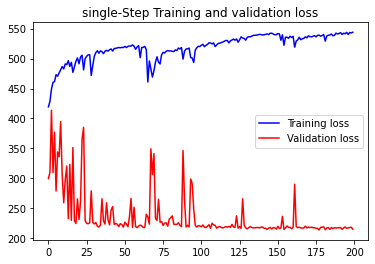

In [114]:
plot_train_history(single_step_history, 'single-Step Training and validation loss')

In [115]:
y1 = None
for x, y in val_data_single.take(10):
  if y1 != None:
    y0 = single_step_model.predict(x)
    print(y0)
    print(y)
#     z = [y1.numpy(), y[BUFFER_SIZE-1].numpy(), y0]
#     show_plot(z, 0, 'Prediction')
  y1 = y

[[464.75165]
 [465.04846]
 [465.12506]
 [465.00415]
 [465.00497]
 [465.044  ]
 [465.04138]
 [464.98648]
 [465.36792]
 [465.24594]
 [465.26224]
 [465.2671 ]
 [465.34106]
 [465.14102]
 [464.87207]
 [464.90625]
 [464.8905 ]
 [464.80847]
 [464.7515 ]
 [465.34518]
 [464.92365]
 [464.83365]
 [465.26843]
 [465.44833]
 [465.4492 ]
 [465.27753]
 [465.1715 ]
 [465.3876 ]
 [465.00604]
 [464.96616]
 [465.418  ]
 [464.92493]
 [464.76157]
 [464.84164]
 [464.85043]
 [464.8512 ]
 [465.029  ]
 [465.06665]
 [464.6147 ]
 [464.71463]
 [464.4252 ]
 [464.5333 ]
 [464.35376]
 [464.5135 ]
 [464.14917]
 [464.49454]
 [464.51828]
 [464.836  ]
 [464.7957 ]
 [464.48083]
 [464.75842]
 [464.8205 ]
 [464.62302]
 [464.711  ]
 [464.73154]
 [464.82162]
 [464.80157]
 [464.43808]
 [464.79742]
 [464.4617 ]
 [464.50378]
 [464.33554]
 [464.57663]
 [464.79382]]
tf.Tensor(
[452. 451. 450. 449. 448. 447. 446. 445. 444. 443. 442. 441. 440. 439.
 438. 437. 436. 435. 434. 433. 432. 431. 430. 429. 428. 427. 426. 425.
 424. 423. 422

In [ ]:
arr = np.array()